#   Bibliotecas

- Versões das bibliotecas no README

In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes


In [2]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [3]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#import de funções do script de pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [5]:
import tensorflow as tf

In [6]:
# Modelo a ser testado
import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13763017345504131641
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2252026676
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12594230100610785223
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [8]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [9]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [10]:
train,test = pre_processamento(train,test)

#   Pré-processamento 

In [11]:
train = textcolumns_junct(train) #Função pra juntar as colunas de texto em uma só coluna

In [12]:
#Convertendo tudo para string

train["item_description"] = train["item_description"].astype(str)

In [13]:
train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.

In [14]:
train["item_description"] = train["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [15]:
train["item_description"] = train["item_description"].apply(lambda x: stemming(x))

In [16]:
train["item_description"]=[" ".join(review) for review in train["item_description"].values]

In [17]:
train["item_description"]

0              mlb cincinnati red shirt size xl descript yet
1          razer blackwidow chroma keyboard razer keyboar...
2          ava viv blous target ador top hint lace key ho...
3          leather hors statu new tag . leather hors . re...
4                 24k gold plate rose complet certif authent
                                 ...                        
1482530    free peopl inspir dress free peopl lace say si...
1482531    littl mermaid handmad dress disney littl merma...
1482532    21 day fix contain eat plan use twice still gr...
1482533    world market lantern 2 one see 2 red 2 orang 2...
1482534    brand new lux de vill wallet new tag red spark...
Name: item_description, Length: 1481661, dtype: object

In [18]:
train.shape

(1481661, 11)

#   Split

In [19]:
#treinando o modelo com valores até $50, que representam 89% do dataset
train1 = train.drop(train[~((train['price'] > 0) & (train['price'] <= 50))].index)

In [51]:
train.shape

(1481661, 11)

In [61]:
Test_extrapolation_50_250.head()

,item_condition_id,category_name,price,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
1,3,Electronics/Computers & Tablets/Components & P...,52.0,0,razer blackwidow chroma keyboard razer keyboar...,15,Electronics,Computers & Tablets,Components & Parts,3.0,2018.0
5,3,Women/Other/Other,59.0,0,bundl item request ruie banana republ bottom c...,6,Women,Other,Other,11.0,2018.0
6,3,Women/Swimwear/Two-Piece,64.0,0,acacia pacif tide santorini top acacia swimwea...,6,Women,Swimwear,Two-Piece,1.0,2018.0
25,3,Men/Shoes/Athletic,66.0,0,air jordan carmin 6s air jordan percent authen...,34,Men,Shoes,Athletic,5.0,2018.0
36,3,Women/Women's Handbags/Totes & Shoppers,209.0,0,black bag 30 pre own . light scratch hardwar c...,9,Women,Women's Handbags,Totes & Shoppers,6.0,2018.0


In [22]:
X = train1.drop("price", axis = 1)
y = train1["price"]

In [23]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de teste de possíveis vazamentos e das mudanças de hyperparametros. 

X1, Xtest, y1, ytest = train_test_split(X, y, test_size=0.1, random_state=10) #Divisão em 90/10

In [24]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=10) #Divisão em 80/20

<AxesSubplot: >

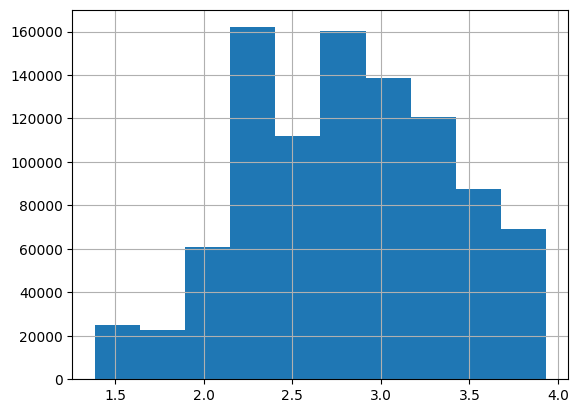

In [25]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

In [26]:
print(Xtrain.shape,ytrain.shape) 
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(958913, 10) (958913,)
(239729, 10) (239729,)
(133183, 10) (133183,)


# Transformadores

In [27]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=25000) #vetorização, com stop word. 

In [28]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<958913x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 23516690 stored elements in Compressed Sparse Row format>

In [29]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<239729x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 5859743 stored elements in Compressed Sparse Row format>

In [30]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<958913x988 sparse matrix of type '<class 'numpy.float64'>'
	with 4794565 stored elements in Compressed Sparse Row format>

In [31]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<239729x988 sparse matrix of type '<class 'numpy.float64'>'
	with 1198633 stored elements in Compressed Sparse Row format>

In [32]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ], format='csr') 
x_train

<958913x25988 sparse matrix of type '<class 'numpy.float64'>'
	with 28311255 stored elements in Compressed Sparse Row format>

In [33]:
x_val = hstack([
                 (vec_val),
                 (ohe_val)
                             ], format='csr') 
x_val

<239729x25988 sparse matrix of type '<class 'numpy.float64'>'
	with 7058376 stored elements in Compressed Sparse Row format>

# Modelo

In [34]:
#del model  # for avoid any trace on aigen
tf.keras.backend.clear_session()  # removing session, it will instance another

In [35]:
input = Input(shape=(x_train.shape[-1]), sparse=True, name='sparse')
dense3 = Dense(1024, activation="relu") (input)
dense4 = Dense(1024, activation="relu") (dense3)
dense5 = Dense(1024, activation="relu") (dense4)
out = Dense(1) (dense5)

model = Model(inputs = input, outputs = out)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse (InputLayer)         [(None, 25988)]           0         
                                                                 
 dense (Dense)               (None, 1024)              26612736  
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 28,712,961
Trainable params: 28,712,961
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss="mean_squared_error", 
              metrics=['mean_squared_error', RootMeanSquaredError()], 
              optimizer = 'Adam')



In [37]:
x_train.sort_indices()

In [38]:

history =  model.fit(x_train,
                     ytrain.values, 
                     batch_size=1024,
                     epochs=20, 
                     verbose=True)

Epoch 1/20


c:\Users\angel\Desktop\Data science\venv\blue_bootcamp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


937/937 [==============================] - 49s 47ms/step - loss: 0.1985 - mean_squared_error: 0.1985 - root_mean_squared_error: 0.4455
Epoch 2/20
937/937 [==============================] - 47s 48ms/step - loss: 0.1322 - mean_squared_error: 0.1322 - root_mean_squared_error: 0.3635
Epoch 3/20
937/937 [==============================] - 47s 48ms/step - loss: 0.0987 - mean_squared_error: 0.0987 - root_mean_squared_error: 0.3142
Epoch 4/20
937/937 [==============================] - 47s 47ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - root_mean_squared_error: 0.2594
Epoch 5/20
937/937 [==============================] - 47s 47ms/step - loss: 0.0459 - mean_squared_error: 0.0459 - root_mean_squared_error: 0.2141
Epoch 6/20
937/937 [==============================] - 47s 47ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - root_mean_squared_error: 0.1837
Epoch 7/20
937/937 [==============================] - 47s 47ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - root_mean_squared_err

In [39]:
x_val.sort_indices()

In [40]:
ypredict = model.predict(x_val)

7492/7492 [==============================] - 28s 4ms/step


In [41]:
ypredict = np.expm1(ypredict)


#   Resultado

- predict validação

In [42]:
print('MAE: $ %.2f' %  mean_absolute_error(yval,ypredict))
print('RMSE:  $ %.2f' %  (mean_squared_error(yval,ypredict)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))


MAE: $ 5.75
RMSE:  $ 8.10
RMSLE: 0.159376
